<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5DEDA_and_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import sys
sys.path.append('/content/gdrive/My Drive')
pd.options.mode.chained_assignment = None 

# Download data

The datasets were downloaded from myanimelist.net (2016)

In [3]:
anime = pd.read_csv('/content/gdrive/My Drive/anime.csv')
anime['episodes'].replace({'Unknown': 0}, inplace = True)
anime['episodes'] = anime['episodes'].astype('float')
anime.dropna(inplace=True)
print(anime.columns)
anime.head()

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [4]:
rating = pd.read_csv('/content/gdrive/My Drive/rating.csv')
rating.dropna(inplace=True)
print(rating.columns)
rating.head()

Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Some statistics:

In [5]:
print(f"Number of users: {len(rating['user_id'].unique())}")
print(f"Number of animes': {len(anime['anime_id'].unique())}")
print(f"Number of animes' per user: {len(rating['user_id'].unique()) / len(rating['anime_id'].unique())}")
print(f"Average number of episodes in an anime:  {anime['episodes'].mean()}")
print(f"Users' average rating: {rating.describe()['rating'].iloc[1]}")

Number of users: 73515
Number of animes': 12017
Number of animes' per user: 6.563839285714286
Average number of episodes in an anime:  12.292419072979945
Users' average rating: 6.144029546937656


Merge the 2 datasets on animes' id. 

In [6]:
data = pd.merge(anime,rating,on='anime_id')
data = data.rename({'rating_y':'user_rating', 'rating_x':'rating'}, axis='columns')
data.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,278,-1


# EDA

Let's prepare a dictionary to draw a nice barplot with genres' frequencies:

In [15]:
def compute_freqs(column):

  # collect names of all genres in the dataset
  gen = []
  for i in data['genre'].values:
    for j in str(i).split():
      gen.append(j.strip(','))

  # genres' names that consist of more than 2 words are shortened: 
  # 'Shounen' and 'Shoujo' means shounen ai and shoujo ai, 'Slice' means slice of life
  gen = [x for x in gen if (x != 'Life' and x != 'of' and x != 'Ai')]
  uni = np.unique(gen)
  freq = []
  for i in uni:
    word_count = gen.count(i)
    freq.append((i,word_count))
  return(dict(freq))

In [16]:
gen_freq = compute_freqs(anime['genre'])

Now we are ready to look at some graphs: rating distribution and genres' frequencies.

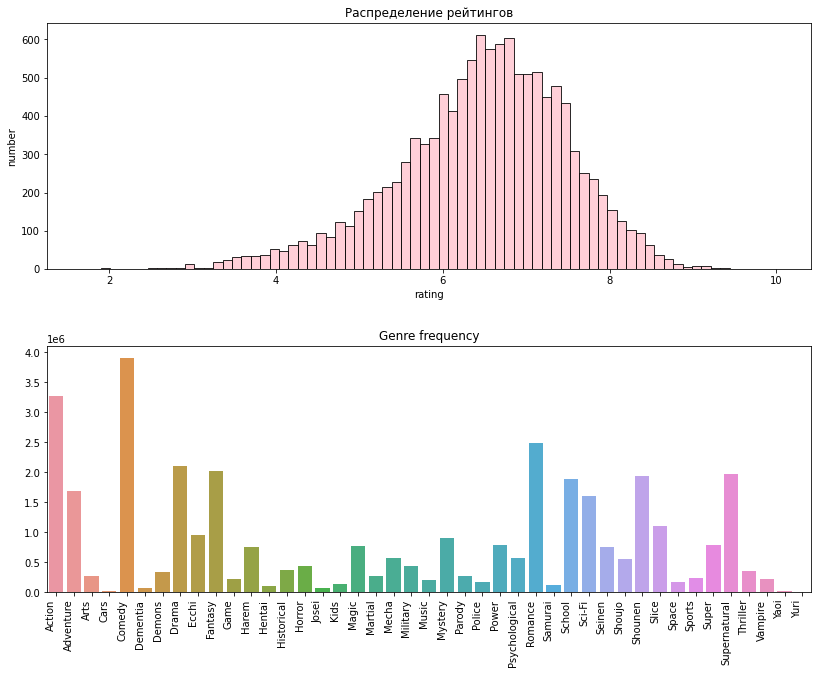

In [17]:
fig, ax = plt.subplots(2, figsize=(12, 10))
sns.histplot(anime['rating'], color='pink', ax=ax[0])
sns.barplot(x=list(gen_freq.keys()), y = list(gen_freq.values()), ax=ax[1])

ax[0].set_title("Распределение рейтингов")
ax[0].set_ylabel("number")
ax[0].set_xlabel("rating")
ax[1].set_title('Genre frequency')

ax[1].set_xticklabels(list(gen_freq.keys()), rotation = 90, ha="right")
fig.tight_layout(pad=3.0)

# save the pic
# plt.savefig('/content/gdrive/My Drive/4 year/gen_info.png')
plt.show()

Why yes, my favorite anime genre is DEMENTIA, how did you know?

# Dataset for a graph

Instead of dealong with continous variable 'user_rating', let's define 'like' - assume that the user likes the anime, if rating > 5 and assign 1 to the 'rating' column, otherwise, assume that the user doesn't like the anime. 

In [18]:
rating_liked = rating.drop(rating[rating['rating'].values < 5].index).drop(columns='rating')

We need to create a specific data shape to feed it to the networkx graph creating algorithm. We need to specify the pairs of the future graph nodes - 'source' and 'target'. In this recommender system we will a homogenous graph with animes and their attributes as nodes. We can also specify the weights of the graph's edges. We will assemble the 'weight' column for all 'source'-'target' pairs from the number of users the nodes of the pair have in common.

First we'll aggregate over the newly created 'rating_liked' to assemble a list of user ids of people who liked each of the animes:

In [19]:
similar_users = rating_liked[rating_liked.duplicated('anime_id', keep=False)].groupby('anime_id')['user_id'].apply(list).reset_index()

print(similar_users.shape)
similar_users.head()

(8744, 2)


,anime_id,user_id
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,..."
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016..."


Later we'll use algrorithm node2vec, which uses random walks on graph to create embeddings from nodes. node2vec is a graph adaptation of word2vec - and it also works with 'sentences'. We'll create a column of attributes which will contain the information about the animes. The column 'attr' basically contains the 'sentences' that we will use later to create the nodes of our graph.

In [37]:
anime_attr = anime[['anime_id', 'name', 'type','genre']]
anime_attr['attr'] = anime_attr['name'] + ' '+ anime_attr['type'] + ' ' + anime_attr['genre']
anime_attr = anime_attr.drop(['name', 'type','genre'], axis=1)

# it seems that out of total 12017 animes users have 'liked' only 8744 animes!!
print(anime_attr.shape)
anime_attr.head()

(12017, 2)


,anime_id,attr
0,32281,"Kimi no Na wa. Movie Drama, Romance, School, S..."
1,5114,"Fullmetal Alchemist: Brotherhood TV Action, Ad..."
2,28977,"Gintama° TV Action, Comedy, Historical, Parody..."
3,9253,"Steins;Gate TV Sci-Fi, Thriller"
4,9969,"Gintama&#039; TV Action, Comedy, Historical, P..."


Now merge 'anime_attr' and 'similar_users' by anime ids:

In [39]:
anime_users = similar_users.merge(anime_attr, on=['anime_id'], how='inner')
print(anime_users.shape)
anime_users.head()

(8733, 3)


,anime_id,user_id,attr
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...","Cowboy Bebop TV Action, Adventure, Comedy, Dra..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...","Cowboy Bebop: Tengoku no Tobira Movie Action, ..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...","Trigun TV Action, Comedy, Sci-Fi"
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117...","Witch Hunter Robin TV Action, Drama, Magic, My..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...","Beet the Vandel Buster TV Adventure, Fantasy, ..."


In [43]:
# there is a mismatch between anime_users and similar_users, 11 animes are present only in the users ratings! hmmm
set(similar_users['anime_id']) - set(anime_users['anime_id'])

{19219, 28655, 28987, 29765, 30484, 30862, 30913, 31507, 31760, 33187, 33242}

We're getting closer to the most harrowing experience of this notebook: we will start from the first anime in the list and run all the way down comparing the first one's list in 'user_id' to the other's. The next iteration starts at the second anime, we will compare its list to the rest of 8731 (we don't compare the anime with itself). In total we will make $(8733-k)$ comparisons $k$ times.

In [ ]:
for_graph_weighted = {}
k = 0
for i in range(1, 8733):
  current_value = set(anime_users[anime_users.index == int(i-1)]['user_id'].values[0])
  for j in range(i, 8733):
    compare_value = set(anime_users[anime_users.index == j]['user_id'].values[0])
    weight = len(current_value & compare_value)
    for_graph_weighted[k] = {'source': anime_users[anime_users.index == int(i-1)]['attr'].values[0], 'target': anime_users[anime_users.index == j]['attr'].values[0], 'weight': weight}
    k += 1

In [ ]:
graph_data = pd.DataFrame.from_dict(for_graph_weighted).T
graph_data = graph_data.drop(graph_data[graph_data['weight'] == 0].index)
graph_data['source'] = graph_data['source'].astype(str)
graph_data['target'] = graph_data['target'].astype(str)
graph_data['weight'] = graph_data['weight'].astype(int)

In [44]:
# save the result and suffer no more
# compression_opts = dict(method='zip', archive_name='fullgraph.csv')
# data.to_csv('fullgraph.zip', index=False, compression=compression_opts)

The resulting dataframe is ready for us to make it a real graph! It has 'source', 'target' and 'weight' columns that represent a connection between a pair of nodes. 

In [65]:
graph_data = pd.read_csv('/content/gdrive/My Drive/4 year/fullgraph.csv')
print(graph_data.shape)
graph_data.head()

(3207183, 3)


,source,target,weight
0,"Cowboy Bebop TV Action, Adventure, Comedy, Dra...","Cowboy Bebop: Tengoku no Tobira Movie Action, ...",5220
1,"Cowboy Bebop TV Action, Adventure, Comedy, Dra...","Trigun TV Action, Comedy, Sci-Fi",6024
2,"Cowboy Bebop TV Action, Adventure, Comedy, Dra...","Witch Hunter Robin TV Action, Drama, Magic, My...",1398
3,"Cowboy Bebop TV Action, Adventure, Comedy, Dra...","Beet the Vandel Buster TV Adventure, Fantasy, ...",160
4,"Cowboy Bebop TV Action, Adventure, Comedy, Dra...","Eyeshield 21 TV Action, Comedy, Shounen, Sports",797


We'll use a package networkx that provides tools for working with graphs to create our first graph here;

In [66]:
graph = nx.from_pandas_edgelist(graph_data, 'source', 'target', 'weight')
nx.info(graph)

'Graph with 8733 nodes and 3207183 edges'

On a histogramm below (cropped it at the top to look closer though) we can see the distribution of weights among the pairs:

In [70]:
wt = nx.get_edge_attributes(graph, 'weight')

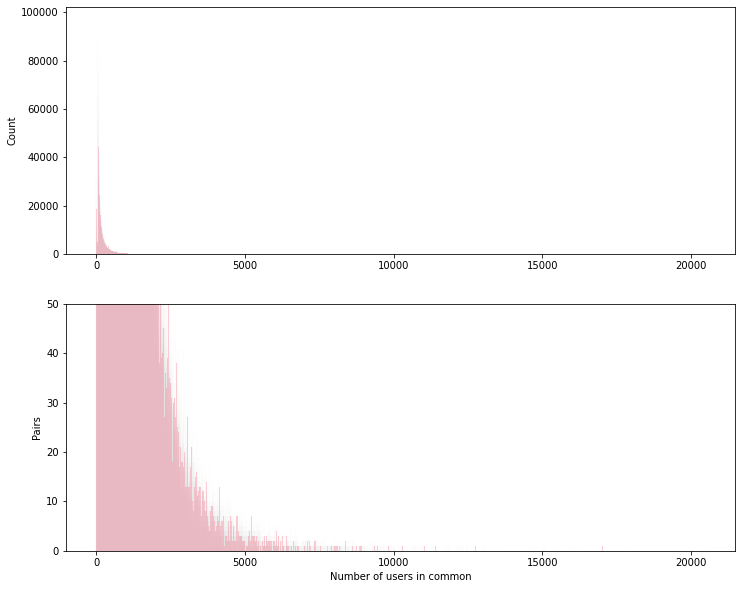

In [75]:
fig, ax = plt.subplots(2, figsize=(12, 10))

sns.histplot(wt, color='pink', ax=ax[0])
plt.ylim(bottom=-0, top=1000)
plt.ylabel("Pairs")
plt.xlabel("Number of users in common")

sns.histplot(wt, color='pink', ax=ax[1])
plt.ylim(bottom=-0, top=50)
plt.ylabel("Pairs")
plt.xlabel("Number of users in common")
plt.show()

Now we only need to make this graph a little bit less dense, otherwise it will be impossible to predict anything on it - all the possible conncetions already exist. Let's drop the pairs where the weight is less than 200. 

In [47]:
graph_data = graph_data.drop(graph_data[graph_data['weight'] <= 200].index)

# Story of one anime